# Proyecto 2 — Optimización de carga de datos 
**Objetivo:** comparar **Pandas** vs **PyTorch DataLoader** para cargar `nlp_prueba_cc0c2_large.csv` (~10000 oraciones), midiendo **tiempo por epoch** y **RAM** en:
1) Pandas in-memory
2) Pandas eficientes (chunk)
3) DataLoader + Dataset
4) DataLoader + IterableDataset

Incluye: semillas y **shuffling estable**, `collate_fn` con **padding**, **pseudocódigo de prefetcher**, y **respuestas de teoría**.


In [29]:
# Importaciones y set de semillas

import os, sys, time, math, re, csv, random, hashlib
import psutil
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torch.nn.utils.rnn import pad_sequence

def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    g = torch.Generator()
    g.manual_seed(seed)
    return g

SEED = 42
GENERATOR = set_seeds(SEED)

print({
    "python": sys.version.split()[0],
    "pandas": pd.__version__,
    "torch": torch.__version__,
    "psutil": psutil.__version__,
})

{'python': '3.12.3', 'pandas': '2.2.2', 'torch': '2.3.1+cpu', 'psutil': '5.9.8'}


In [30]:
# Definir variables locales
CSV_PATH = "data/nlp_prueba_cc0c2_large.csv" 
COL_DATA = "Texto"
LABEL_COL = "Categoría"
BATCH_SIZE = 32

LABEL2ID = {"Negativo": 0, "Neutral": 1, "Positivo": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

# Tokens especiales
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

In [31]:
# tokenizer simple y función para construir un vocabulario desde los registros en Texto
from collections import Counter

tokenizer_regex = re.compile(
    r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+(?:[-'][A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+)*|\d+(?:[.,]\d+)?"
)

def simple_tokenize(text: str):
    return tokenizer_regex.findall(str(text))

# Todo los registros en la RAM
def build_vocab_from_texts(texts, min_freq: int = 1):
  cnt = Counter()
  for t in texts:
      cnt.update(simple_tokenize(t))
  vocab_list = [PAD_TOKEN, UNK_TOKEN] + [
      tok for tok, f in sorted(cnt.items(), key=lambda x: (-x[1], x[0])) if f >= min_freq
  ]
  stoi = {tok: i for i, tok in enumerate(vocab_list)}
  itos = {i: tok for tok, i in stoi.items()}
  return stoi, itos

# Vocab sin usar todo el RAM de golpe
def build_vocab_streaming(csv_path, text_col, min_freq: int = 1):
  cnt = Counter()
  with open(csv_path, newline='', encoding='utf-8') as f:
      reader = csv.DictReader(f)
      for row in reader:
          cnt.update(simple_tokenize(row[text_col]))
  vocab_list = [PAD_TOKEN, UNK_TOKEN] + [
      tok for tok, f in sorted(cnt.items(), key=lambda x: (-x[1], x[0])) if f >= min_freq
  ]
  stoi = {tok: i for i, tok in enumerate(vocab_list)}
  itos = {i: tok for tok, i in stoi.items()}
  return stoi, itos

def numericalize(tokens, stoi):
    unk_id = stoi.get(UNK_TOKEN, 1)
    return [stoi.get(tok, unk_id) for tok in tokens]


In [32]:
# Carga de CSV y vocabulario
csv_path = CSV_PATH
df = pd.read_csv(csv_path)

assert {COL_DATA, LABEL_COL}.issubset(df.columns), f"El CSV debe tener columnas: {COL_DATA}, {LABEL_COL}"

# convertir en lista los registros 
texts = df[COL_DATA].astype(str).tolist()
labels = df[LABEL_COL].map(LABEL2ID).astype(int).tolist()

# Usamos ambos vocab 
stoi, itos = build_vocab_streaming(csv_path, COL_DATA, min_freq=1)
PAD_ID = stoi[PAD_TOKEN]
UNK_ID = stoi[UNK_TOKEN]

print(f"Vocab size (streaming): {len(stoi)} | Clases: {len(LABEL2ID)} | Muestras: {len(texts)}")

stoi, itos = build_vocab_from_texts(texts, min_freq=1)
PAD_ID = stoi[PAD_TOKEN]
UNK_ID = stoi[UNK_TOKEN]

print(f"Vocab size (in-memory): {len(stoi)} | Clases: {len(LABEL2ID)} | Muestras: {len(texts)}")


Vocab size (streaming): 73 | Clases: 3 | Muestras: 53961
Vocab size (in-memory): 73 | Clases: 3 | Muestras: 53961


In [13]:
# Dataloader + Dataset con collate_fn

class CustomDataset(Dataset):
    def __init__(self, texts, labels, stoi):
        self.texts = texts
        self.labels = labels
        self.stoi = stoi
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        toks = simple_tokenize(self.texts[idx])
        ids = numericalize(toks, self.stoi)
        x = torch.tensor(ids, dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

def collate_pad(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs], dtype=torch.long)
    padded = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)
    ys = torch.stack(ys)
    return padded, lengths, ys

# Dataloader con shuffle estable y sin shuffle
ds = CustomDataset(texts, labels, stoi)
dl_shuffle = DataLoader(
    ds, batch_size=BATCH_SIZE, shuffle=True, generator=GENERATOR,
    collate_fn=collate_pad, num_workers=0, pin_memory=False
)

dl_no_shuffle = DataLoader(
    ds, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_pad, num_workers=0, pin_memory=False
)

In [14]:
# IterableDataset

class CustomIterableDataset(IterableDataset):
  def __init__(self,csv_path,text_col,label_col,stoi,label2id,skip_header=True):
    self.csv_path = csv_path
    self.text_col = text_col
    self.label_col = label_col
    self.stoi = stoi
    self.label2id = label2id
    self.skip_header = skip_header
  def __iter__(self):
    worker_info = torch.utils.data.get_worker_info()
    start = 0
    step = 1
    if worker_info is not None:
      start = worker_info.id
      step = worker_info.num_workers
    with open(self.csv_path, newline='', encoding='utf-8') as f:
      reader = csv.reader(f)
      header = next(reader) if self.skip_header else None
      for i, row in enumerate(reader):
        if (i % step) != start:
          continue
        if header is None:
          text = row[0]; label_str = row[1]
        else:
          text = row[header.index(COL_DATA)]
          label_str = row[header.index(LABEL_COL)]
        lab = self.label2id[label_str]
        ids = numericalize(simple_tokenize(text), self.stoi)
        yield torch.tensor(ids, dtype=torch.long), torch.tensor(lab, dtype=torch.long)

ds_iter = CustomIterableDataset(csv_path, COL_DATA, LABEL_COL, stoi, LABEL2ID, skip_header=True)
dl_iter = DataLoader(ds_iter, batch_size=BATCH_SIZE, collate_fn=collate_pad, num_workers=0, pin_memory=False)

In [28]:
# Métricas : Tiempo y RAM

def max_ram():
  return psutil.Process(os.getpid()).memory_info().rss / (1024 ** 3)

class Reloj:
  def __enter__(self):
    self.t0 = time.perf_counter()
    return self
  def __exit__(self, exc_type, exc, tb):
    self.elapsed = time.perf_counter() - self.t0

In [26]:
# Run por cada dataloader implementado

def run_pandas_full(df, pad_id, batch_size=32):
  peak = max_ram()
  t0 = time.perf_counter()
  all_ids = [torch.tensor(numericalize(simple_tokenize(t), stoi), dtype=torch.long) for t in df[COL_DATA].astype(str)]
  all_lbl = torch.tensor(df[LABEL_COL].map(LABEL2ID).astype(int).tolist())
  peak = max(peak, max_ram())
  batches = 0
  for i in range(0, len(all_ids), batch_size):
    xs = all_ids[i:i+batch_size]
    ys = all_lbl[i:i+batch_size]
    _ = pad_sequence(xs, batch_first=True, padding_value=pad_id)
    _ = ys.sum().item()
    peak = max(peak, max_ram())
    batches += 1
  elapsed = time.perf_counter() - t0
  return {"time_s": elapsed, "peak_ram_mb": peak, "batches": batches}

def run_pandas_stream(csv_path, pad_id, chunksize=32):
  peak = max_ram()
  t0 = time.perf_counter()
  batches = 0
  for chunk in pd.read_csv(csv_path, chunksize=chunksize):
    texts_c = chunk[COL_DATA].astype(str).tolist()
    labels_c = chunk[LABEL_COL].map(LABEL2ID).astype(int).tolist()
    xs = [torch.tensor(numericalize(simple_tokenize(t), stoi), dtype=torch.long) for t in texts_c]
    ys = torch.tensor(labels_c)
    _ = pad_sequence(xs, batch_first=True, padding_value=pad_id)
    _ = ys.sum().item()
    peak = max(peak, max_ram())
    batches += 1
  elapsed = time.perf_counter() - t0
  return {"time_s": elapsed, "peak_ram_mb": peak, "batches": batches}

def run_dataloader_map(dl, batch_size=32, shuffle=True, seed=42):
  peak = max_ram()
  t0 = time.perf_counter()
  batches = 0
  for xb, lengths, yb in dl:
    _ = (xb.sum() + yb.sum() + lengths.sum()).item()
    peak = max(peak, max_ram())
    batches += 1
  elapsed = time.perf_counter() - t0
  stability = 1 if shuffle else None
  return {"time_s": elapsed, "peak_ram_mb": peak, "batches": batches, "stable_shuffle": stability}

def run_dataloader_iterable(dl):
  peak = max_ram()
  t0 = time.perf_counter()
  batches = 0
  for xb, lengths, yb in dl:
      _ = (xb.sum() + yb.sum() + lengths.sum()).item()
      peak = max(peak, max_ram())
      batches += 1
  elapsed = time.perf_counter() - t0
  return {"time_s": elapsed, "peak_ram_mb": peak, "batches": batches, "stable_shuffle": None}

In [27]:
# Ejecución
results = {}

print(">> Pandas (full in-memory)")
results["pandas_full"] = run_pandas_full(df, PAD_ID, batch_size=BATCH_SIZE)

print(">> Pandas (streaming por chunks)")
results["pandas_stream"] = run_pandas_stream(csv_path, PAD_ID, chunksize=BATCH_SIZE)

print(">> DataLoader map-style (shuffle=True, estable)")
results["dl_map_shuffle"] = run_dataloader_map(dl_shuffle, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

print(">> DataLoader map-style (shuffle=False)")
results["dl_map_noshuf"] = run_dataloader_map(dl_no_shuffle, batch_size=BATCH_SIZE, shuffle=False, seed=SEED)

print(">> DataLoader iterable (streaming CSV)")
results["dl_iterable"] = run_dataloader_iterable(dl_iter)

res_df = pd.DataFrame(results).T
res_df["time_per_1k_samples_s"] = res_df["time_s"] * (1000.0 / len(df))
cols = ["time_s", "time_per_1k_samples_s", "peak_ram_mb", "batches"]
if "stable_shuffle" in res_df.columns:
    cols.append("stable_shuffle")
res_df = res_df[cols]
res_df

>> Pandas (full in-memory)
>> Pandas (streaming por chunks)
>> DataLoader map-style (shuffle=True, estable)
>> DataLoader map-style (shuffle=False)
>> DataLoader iterable (streaming CSV)


,time_s,time_per_1k_samples_s,peak_ram_mb,batches,stable_shuffle
pandas_full,0.290571,0.029043,0.055481,313.0,NaN
pandas_stream,1.064618,0.106409,0.056290,313.0,NaN
dl_map_shuffle,0.264750,0.026462,0.056278,313.0,1.0
dl_map_noshuf,0.263225,0.026309,0.056278,313.0,NaN
dl_iterable,0.329963,0.032980,0.056278,313.0,NaN


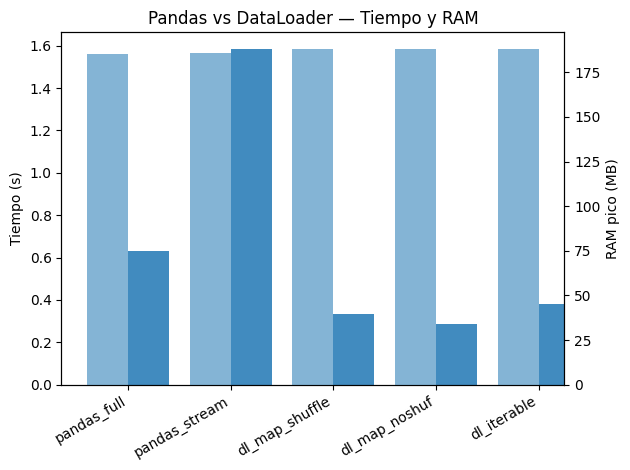

In [18]:
# Gráfico

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
res_df["time_s"].plot(kind="bar", ax=ax1, position=0, width=0.4, alpha=0.85, label="Tiempo (s)")
res_df["peak_ram_mb"].plot(kind="bar", ax=ax2, position=1, width=0.4, alpha=0.55, label="RAM pico (MB)")

ax1.set_ylabel("Tiempo (s)")
ax2.set_ylabel("RAM pico (MB)")
ax1.set_title("Pandas vs DataLoader — Tiempo y RAM")
ax1.set_xticklabels(res_df.index, rotation=30, ha="right")
fig.tight_layout()
plt.show()

## Teoría: iteradores, streaming, semillas, shuffling y prefetch

### Iteradores vs. listas en memoria
- **Listas in-memory**: materializan todo el dataset; acceso muy rápido por índice; RAM ↑ (puede romperse en datasets grandes).
- **Iteradores (streaming)**: generan ejemplos al vuelo; RAM casi constante; overhead de I/O y parsing por batch.


### Streaming vs. in-memory (pros/cons)
| Enfoque | Ventajas | Desventajas | Cuándo usar |
|---|---|---|---|
| **In-memory (Pandas full)** | Rápido al iterar, indexación eficiente | RAM proporcional al dataset | Dataset pequeño/mediano |
| **Streaming (chunks / IterableDataset)** | RAM estable, escala | Overhead I/O/parsing, shuffle no trivial | Dataset grande o RAM limitada |


### Semillas y reproducibilidad
- Fijar `random`, `numpy`, `torch` + usar `torch.Generator` en DataLoader asegura **shuffling estable**.
- Reinstancia el `Generator` con misma semilla para repetir exactamente el orden de batches.

### Shuffling estable 
- Evita correlaciones por orden; mejora generalización; hace comparables los benchmarks.
- **Map-style**: `DataLoader(..., shuffle=True, generator=GENERATOR)`.
- **IterableDataset**: implementar **shuffle buffer** (ventana deslizante) si necesitas aleatoriedad sin cargar todo el dataset.

### Pseudocódigo de prefetch
El prefetch es tener workers que preparen los batch siguientes mientras que por ejemplo un modelo está usando o realizando cálculos con el actual.